# Prepare Pretrained GPT2 Indonesian

In [1]:
import transformers, datasets, evaluate, sacrebleu
print(transformers.__version__)
print(datasets.__version__)
print(evaluate.__version__)
print(sacrebleu.__version__)

4.30.1
2.12.0
0.4.0
2.3.1


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Prepare Pre-trained Model

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("cahya/gpt2-small-indonesian-522M")
model = AutoModelForCausalLM.from_pretrained("cahya/gpt2-small-indonesian-522M")

model.config.pad_token_id = model.config.eos_token_id
model.generation_config.pad_token_id = model.generation_config.eos_token_id

tokenizer.add_special_tokens({"pad_token": "<pad>", 
                              "bos_token": "<bos>",
                              "eos_token": "<eos>"}                             
)
tokenizer.add_tokens(["<bot>"])

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

In [4]:
print(device)

cuda


# Prepare Dataset

# Prepare STIF Dataset

In [5]:
import re
import requests
import os

#convert txt to tsv
def get_txt_to_tsv(filename):
    txt=filename+".txt"
    tsv=filename+".tsv"
    path="stif-dataset/"+tsv
    url="https://raw.githubusercontent.com/Razorcone/normalization/main/"+txt
    response = requests.get(url)
    open(txt, "wb").write(response.content)
    with open(txt, 'r') as reader:
        text = reader.read()

    text = re.sub(r"(...)\n", r"\t", text)
    print(text)

    with open(path, 'w') as writer:
        writer.write(text)
    os.remove(txt)
    
#os.mkdir("stif-dataset")
get_txt_to_tsv("train.inf")
get_txt_to_tsv("train.for")
get_txt_to_tsv("dev.inf")
get_txt_to_tsv("dev.for")
get_txt_to_tsv("test.inf")
get_txt_to_tsv("test.for")

alhamdulillah stlh libur xxxnumberxxx hari onbid lgsg dikasih orderan , food lg . thanks xxxuserxxx	selamat sore min . saya mau pesan tiket ka via web , tetapi selalu tertulis " terjadi kesalahan pada sistem " mohon solusinya . terima ka	iya kak terimakasih . tapi tadi sudah datang ke galeri indosatnya langsung . sudah normal l	malam min xxxuserxxx xxxuserxxx situs kalian error ya . mau order dari siang tadi ga bisa	min pembelian token pln apa ada kendala , ini blm masuk udah xxxnumberxxx jam lebi	udah udah sampe mana ya ? masa ke bintara aja ga sampe ? ( tolong follow	sinyal xxxnumberxxx beberapa hari ini kok bapuk banget ya ? ga stabil , lemot . ada apaka	saldo kepotong tapi uang nggak keluar . ini udah kali kedua saya melakukan penarikan tunai di at	gimana cara pengambilan paket datanya min xxxuserxxx ? sudah cek my telkomsel dan * xxxnumberxxx gak tersedia	bni corporate gangguan kah ? saya coba buka gabisa te	daripada lapor ke xxxuserxxx xxxuserxxx , mending ke xxxuserxxx . pelayan

In [6]:
##training data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd

train_data_inf=list(pd.read_csv('stif-dataset/train.inf.tsv',sep='\t'))
train_data_for=list(pd.read_csv('stif-dataset/train.for.tsv',sep='\t'))
dev_data_inf = list(pd.read_csv('stif-dataset/dev.inf.tsv', sep='\t'))
dev_data_for = list(pd.read_csv('stif-dataset/dev.for.tsv', sep='\t'))
test_data_inf = list(pd.read_csv('stif-dataset/dev.inf.tsv', sep='\t'))
test_data_for = list(pd.read_csv('stif-dataset/dev.for.tsv', sep='\t'))

class STIFData(Dataset):
    def __init__(self, tokenizer, param):
        if param=="training":
            self.informal = train_data_inf
            self.formal = train_data_for
        elif param=="validation":
            self.informal = dev_data_inf
            self.formal = dev_data_for
        else :
            self.informal = test_data_inf
            self.formal = test_data_for
        
        self.paired = []

        for i in range(len(self.informal)):
          self.paired.append("<bos>"+self.informal[i]+"<bot>"+self.formal[i]+"<eos>")


        # Determine the maximum length of the input sequences
        max_sequence_length = max(len(seq) for seq in self.paired)

        # Set the desired minimum maximum length for padding
        min_max_new_tokens = 20

        # Calculate the final value for max_new_tokens
        max_new_tokens = max(max_sequence_length, min_max_new_tokens)

        # Tokenize and pad the paired sequences
        self.encoded = tokenizer(
            self.paired,
            max_length=None,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        
        #self.encoded = tokenizer.pad(self.encoded, max_length=max_new_tokens, padding="max_length")
        
        self.input_ids = self.encoded['input_ids']
        self.attention_mask = self.encoded['attention_mask']
    def getLabel(self):
        return self.formal()
    def __len__(self):
        return len(self.paired)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_mask[idx])

train_data = STIFData(tokenizer,"training")
train_data = DataLoader(train_data, batch_size=32)
dev_data = STIFData(tokenizer,"validation")
dev_data = DataLoader(dev_data, batch_size=32)
test_data = STIFData(tokenizer,"testing")
test_data = DataLoader(test_data, batch_size=32)

# Prepare Training

In [7]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training

In [8]:
import tqdm 
import torch.nn as nn

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def compute_accuracy(predictions, targets):
    predictions = predictions.argmax(dim=-1)
    correct = (predictions == targets).sum().item()
    total = targets.numel()
    return correct / total

def train(dataset, dev_dataset, model, optim):
    epochs = 30
    dropout_rate=0.2
    criterion = nn.CrossEntropyLoss()
    dropout_layer = nn.Dropout(dropout_rate)
    
    for i in tqdm.tqdm(range(epochs), disable=True):
        total_loss = 0.0
        total_acc = 0.0
        
        model.train()
        for X, a in dataset:
            X = X.to(device)
            a = a.to(device)
            optimizer.zero_grad()
            outputs = model(X, attention_mask=a, labels=X)
            
            logits = outputs.logits
            loss = criterion(logits.view(-1, model.config.vocab_size), X.view(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_acc += compute_accuracy(logits, X)
            
            logits = dropout_layer(logits)
            
        average_loss = total_loss / len(dataset)
        average_acc = total_acc / len(dataset)
        
        train_losses.append(average_loss)
        train_accuracies.append(average_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            total_val_acc = 0.0
            
            for X_val, a_val in dev_dataset:
                X_val = X_val.to(device)
                a_val = a_val.to(device)
                val_outputs = model(X_val, attention_mask=a_val, labels=X_val)
                val_logits = val_outputs.logits
                val_loss = criterion(val_logits.view(-1, model.config.vocab_size), X_val.view(-1))
                
                
                total_val_loss += val_loss.item()
                total_val_acc += compute_accuracy(val_logits, X_val)
                
            average_val_loss = total_val_loss / len(dev_dataset)
            average_val_acc = total_val_acc / len(dev_dataset)
            val_losses.append(average_val_loss)
            val_accuracies.append(average_val_acc)

        scheduler.step(average_val_acc)
        print(f"Epoch {i + 1}: Training Loss={average_loss:.4f}, Training Acc={average_acc:.4f}, "
              f"\nValidation Loss={average_val_loss:.4f}, Validation Acc={average_val_acc:.4f},"
              f"\nLearning Rate = {optim.param_groups[0]['lr']:.6f}")
        print(infer("Halo, bagaimana kabarmu?"))
        torch.save(model.state_dict(), "model_state.pt")

def infer(inp):
    inp = "<bos> "+inp+" <bot> "
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device)
    a = inp["attention_mask"].to(device)
    output = model.generate(X, attention_mask=a)
    output = tokenizer.decode(output[0])
    return output

In [9]:
model.to(device)
print("training .... ")
train(train_data,dev_data, model, optimizer)

training .... 
Epoch 1: Training Loss=5.0091, Training Acc=0.6586, 
Validation Loss=4.5878, Validation Acc=0.5732,
Learning Rate = 0.001000
<bos> Halo, bagaimana kabarmu? <bot> <pad><pad><pad><pad><pad><pad><pad><pad><pad>


/home/fathur/.conda/envs/py39/lib/python3.9/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 2: Training Loss=1.6335, Training Acc=0.7940, 
Validation Loss=2.4765, Validation Acc=0.6430,
Learning Rate = 0.001000
<bos> Halo, bagaimana kabarmu? <bot>          
Epoch 3: Training Loss=0.8105, Training Acc=0.8692, 
Validation Loss=0.4778, Validation Acc=0.9133,
Learning Rate = 0.001000
<bos> Halo, bagaimana kabarmu? <bot>          
Epoch 4: Training Loss=0.0570, Training Acc=0.9882, 
Validation Loss=0.0118, Validation Acc=0.9971,
Learning Rate = 0.001000
<bos> Halo, bagaimana kabarmu? <bot>          
Epoch 5: Training Loss=0.0016, Training Acc=0.9997, 
Validation Loss=0.0056, Validation Acc=0.9986,
Learning Rate = 0.001000
<bos> Halo, bagaimana kabarmu? <bot>          
Epoch 6: Training Loss=0.0003, Training Acc=1.0000, 
Validation Loss=0.0059, Validation Acc=0.9985,
Learning Rate = 0.001000
<bos> Halo, bagaimana kabarmu? <bot>          
Epoch 7: Training Loss=0.0002, Training Acc=1.0000, 
Validation Loss=0.0056, Validation Acc=0.9985,
Learning Rate = 0.001000
<bos> Halo, bag

KeyboardInterrupt: 

In [10]:
output = model.generate(X, attention_mask=a)
output = tokenizer.decode(output[0])

AttributeError: 'str' object has no attribute 'shape'

In [19]:
print("infer from model : ")
while True:
  inp = input()
  print(infer(inp))

infer from model : 


 HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOo


Input length of input_ids is 104, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


<bos> HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOo <bot>  


KeyboardInterrupt: Interrupted by user

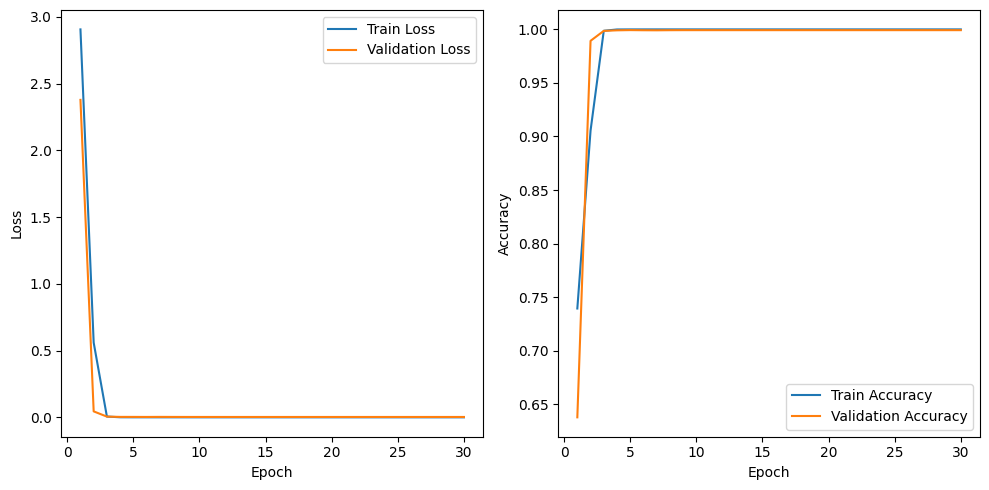

In [12]:
import matplotlib.pyplot as plt
# Plotting
epochs = 30
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

filename = "Pengujian v1-3"
plt.tight_layout()
plt.savefig(filename+'.png', bbox_inches='tight')
torch.save(model.state_dict(), filename+".pt")
plt.show()

<Figure size 640x480 with 0 Axes>

In [12]:
import tqdm
from nltk.translate.bleu_score import sentence_bleu
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def compute_perplexity(predictions, targets):
    cross_entropy = F.cross_entropy(predictions.view(-1, predictions.size(-1)), targets.view(-1), reduction='sum')
    num_words = targets.ne(0).sum().item()  # Count the number of non-padding words
    perplexity = torch.exp(cross_entropy / num_words)
    return perplexity.item()

def compute_bleu_score(predictions, targets):
    hypotheses = [tokenizer.decode(output, skip_special_tokens=True) for output in predictions]
    references = [tokenizer.decode(target, skip_special_tokens=True) for target in targets]
    bleu_score = sentence_bleu(references, hypotheses)
    return bleu_score

def train(dataset, dev_dataset, model, optimizer, tokenizer):
    epochs = 30

    for i in tqdm.tqdm(range(epochs), disable=True):
        total_loss = 0.0
        total_acc = 0.0
        total_perplexity = 0.0
        total_bleu = 0.0

        model.train()
        for X, a in dataset:
            X = X.to(device)
            a = a.to(device)
            optimizer.zero_grad()
            outputs = model(X, attention_mask=a, labels=X)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

            perplexity = compute_perplexity(logits, X)
            bleu_score = compute_bleu_score(model.generate(X, attention_mask=a), X)

            total_loss += loss.item()
            total_acc += compute_accuracy(logits, X)
            total_perplexity += perplexity
            total_bleu += bleu_score

        average_loss = total_loss / len(dataset)
        average_acc = total_acc / len(dataset)
        average_perplexity = total_perplexity / len(dataset)
        average_bleu = total_bleu / len(dataset)

        # Validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            total_val_acc = 0.0
            total_val_perplexity = 0.0
            total_val_bleu = 0.0

            for X_val, a_val in dev_dataset:
                X_val = X_val.to(device)
                a_val = a_val.to(device)
                val_outputs = model(X_val, attention_mask=a_val, labels=X_val)
                val_loss = val_outputs.loss
                val_logits = val_outputs.logits

                val_perplexity = compute_perplexity(val_logits, X_val)
                val_bleu_score = compute_bleu_score(model.generate(X_val, attention_mask=a_val), X_val)

                total_val_loss += val_loss.item()
                total_val_acc += compute_accuracy(val_logits, X_val)
                total_val_perplexity += val_perplexity
                total_val_bleu += val_bleu_score

            average_val_loss = total_val_loss / len(dev_dataset)
            average_val_acc = total_val_acc / len(dev_dataset)
            average_val_perplexity = total_val_perplexity / len(dev_dataset)
            average_val_bleu = total_val_bleu / len(dev_dataset)

        scheduler.step(average_val_acc)
        print(f"Epoch {i + 1}: Training Loss={average_loss:.4f}, Training Acc={average_acc:.4f}, "
              f"Training Perplexity={average_perplexity:.4f}, Training BLEU={average_bleu:.4f}, "
              f"\nValidation Loss={average_val_loss:.4f}, Validation Acc={average_val_acc:.4f}, "
              f"Validation Perplexity={average_val_perplexity:.4f}, Validation BLEU={average_val_bleu:.4f}, "
              f"\nLearning Rate = {optim.param_groups[0]['lr']:.6f}")
        torch.save(model.state_dict(), "model_state.pt")


In [ ]:
model.to(device)
model.train()
print("training .... ")
train(train_data,dev_data, model, optimizer,tokenizer)

training .... 


/home/fathur/.conda/envs/py39/lib/python3.9/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 215, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 215, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 215, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 215, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_

KeyboardInterrupt: 